In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from itertools import product
from scipy import stats
from tqdm import tqdm

In [3]:
def get_list_from_file(filename, eval_needed=False):
  full_list = []
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      value = ast.literal_eval(line.strip()) if eval_needed else line.strip()
      full_list.append(value)
  return full_list

In [4]:
def get_embeddings(skills_name='all_skills.txt', embedding_name='10_embeddings.txt'):
  return dict(zip(get_list_from_file(skills_name), get_list_from_file(embedding_name, eval_needed=True)))

In [5]:
def correct_read(filename, transform_columns='skills'):
  df = pd.read_csv(filename)
  df.loc[:, transform_columns] = df.loc[:, transform_columns].apply(ast.literal_eval)
  return df

In [6]:
def change_all_skills(skill_list, skills_to_embeddings):
  return np.array([skills_to_embeddings[x.strip().lower()] for x in skill_list])

In [7]:
def replace_by_embedding(df, embeddings, R=1, embedded_column='skills'):

    col = df[embedded_column]
    embedded = col.apply(lambda x: change_all_skills(x, embeddings), embeddings)

    changed_df = df.copy()
    changed_df.loc[:, embedded_column] = R*embedded

    return changed_df

In [8]:
def get_distances(resume_object, vacancy_object, vac_to_obj=False, R=1):

  if vacancy_object.shape[0] == 0 or resume_object.shape[0] == 0:
      return None

  res = [R*np.arccos(np.dot(res, vac)/R**2) for res,vac in product(resume_object, vacancy_object)]

  if vac_to_obj:
    res = np.array(res).reshape(vacancy_object.shape[0], resume_object.shape[0])
  else:
    res = np.array(res).reshape(resume_object.shape[0], vacancy_object.shape[0])
  return res

In [9]:
def get_all_matrices(df, skill_column='skills', vac_num=1, res_num=0):

  vac_skills = df[df.Type == vac_num].loc[:, skill_column]
  res_skills = df[df.Type == res_num].loc[:, skill_column]

  return [get_distances(res, vac) for vac, res in product(vac_skills, res_skills)]

In [211]:
#min weight assignment
class KMMatcher:

    ## weights : nxm weight matrix (numpy , float), n <= m
    def __init__(self, weights):
        weights = -np.array(weights).astype(np.float32)
        self.weights = weights
        self.n, self.m = weights.shape
        assert self.n <= self.m
        # init label
        self.label_x = np.max(weights, axis=1)
        self.label_y = np.zeros((self.m, ), dtype=np.float32)

        self.max_match = 0
        self.xy = -np.ones((self.n,), dtype=int)
        self.yx = -np.ones((self.m,), dtype=int)

    def do_augment(self, x, y):
        self.max_match += 1
        while x != -2:
            self.yx[y] = x
            ty = self.xy[x]
            self.xy[x] = y
            x, y = self.prev[x], ty

    def find_augment_path(self):
        self.S = np.zeros((self.n,), bool)
        self.T = np.zeros((self.m,), bool)

        self.slack = np.zeros((self.m,), dtype=np.float32)
        self.slackyx = -np.ones((self.m,), dtype=int)  # l[slackyx[y]] + l[y] - w[slackx[y], y] == slack[y]

        self.prev = -np.ones((self.n,), int)

        queue, st = [], 0
        root = -1

        for x in range(self.n):
            if self.xy[x] == -1:
                queue.append(x);
                root = x
                self.prev[x] = -2
                self.S[x] = True
                break

        self.slack = self.label_y + self.label_x[root] - self.weights[root]
        self.slackyx[:] = root

        while True:
            while st < len(queue):
                x = queue[st]; st+= 1

                is_in_graph = np.isclose(self.weights[x], self.label_x[x] + self.label_y)
                nonzero_inds = np.nonzero(np.logical_and(is_in_graph, np.logical_not(self.T)))[0]

                for y in nonzero_inds:
                    if self.yx[y] == -1:
                        return x, y
                    self.T[y] = True
                    queue.append(self.yx[y])
                    self.add_to_tree(self.yx[y], x)

            self.update_labels()
            queue, st = [], 0
            is_in_graph = np.isclose(self.slack, 0)
            nonzero_inds = np.nonzero(np.logical_and(is_in_graph, np.logical_not(self.T)))[0]

            for y in nonzero_inds:
                x = self.slackyx[y]
                if self.yx[y] == -1:
                    return x, y
                self.T[y] = True
                if not self.S[self.yx[y]]:
                    queue.append(x)
                    self.add_to_tree(self.yx[y], x)

    def solve(self, verbose = False):

        while self.max_match < self.n:
            x, y = self.find_augment_path()
            self.do_augment(x, y)

        sum = 0.

        self.weights = -self.weights

        for x in range(self.n):
            if verbose:
                print('match {} to {}, weight {:.4f}'.format(x, self.xy[x], self.weights[x, self.xy[x]]))
            sum += self.weights[x, self.xy[x]]
        self.best = sum
        if verbose:
            print('ans: {:.4f}'.format(sum))
        return sum


    def add_to_tree(self, x, prevx):
        self.S[x] = True
        self.prev[x] = prevx

        better_slack_idx = self.label_x[x] + self.label_y - self.weights[x] < self.slack
        self.slack[better_slack_idx] = self.label_x[x] + self.label_y[better_slack_idx] - self.weights[x, better_slack_idx]
        self.slackyx[better_slack_idx] = x

    def update_labels(self):
        delta = self.slack[np.logical_not(self.T)].min()
        self.label_x[self.S] -= delta
        self.label_y[self.T] += delta
        self.slack[np.logical_not(self.T)] -= delta

In [205]:
def more_vacancy_skills(matrix):

    res_skill_num = matrix.shape[0]
    vac_skill_num = matrix.shape[1]

    zeros = np.zeros(shape=(vac_skill_num-res_skill_num, vac_skill_num))
    new_matrix = np.concatenate([matrix, zeros], axis=0)

    matcher = KMMatcher(new_matrix)
    res = matcher.solve()

    weights = matcher.weights
    num_no_destination = np.sum(~weights.any(axis=1))

    indices = matcher.xy
    no_destination = indices[-num_no_destination:]

    additional = np.sum(np.min(matrix[:, no_destination], axis=0))

    return res + additional

In [206]:
def more_resume_skills(matrix):

    res_skill_num = matrix.shape[0]
    vac_skill_num = matrix.shape[1]

    zeros = np.zeros(shape=(res_skill_num, res_skill_num-vac_skill_num))
    new_matrix = np.concatenate([matrix, zeros], axis=1)

    matcher = KMMatcher(new_matrix)
    res = matcher.solve()

    return res

In [207]:
def get_all_distances(res_skills, vac_skills):

    all_distances = np.zeros(shape=(res_skills.shape[0], vac_skills.shape[0]))

    for num_res, res in enumerate(res_skills):
      min_length = np.zeros_like(vac_skills)
      for num_vac, vac in enumerate(vac_skills):

        matrix = get_distances(res, vac)
        if matrix is None:
          continue

        if res.shape[0] >= vac.shape[0]:
          distance = more_resume_skills(matrix)
        else:
          distance = more_vacancy_skills(matrix)

        min_length[num_vac] = distance

      all_distances[num_res] = min_length

    return np.argsort(all_distances), all_distances

In [14]:
def experiment(skillname='all_skills.txt', skill_column='skills',
               df_name='ResVacDataset.csv', R=1, dim_list = None):

    full_df = correct_read(df_name)

    if dim_list is None:
      dim_list = [256, 1024, 3072]

    for dim in dim_list:

      cur_embeddings = get_embeddings(skillname, f"{dim}_embeddings.txt")
      embedded_df = replace_by_embedding(full_df, cur_embeddings, R=R,
                                         embedded_column=skill_column)

      vac_skills = embedded_df[embedded_df.Type == 1].skills
      res_skills = embedded_df[embedded_df.Type == 0].skills

      order, distances = get_all_distances(res_skills, vac_skills)

      np.save(f"{dim}_order.txt", order)
      np.save(f"{dim}_distances.txt", distances)

      return order, distances

In [15]:
#experiment(dim_list=[1024])

In [ ]:
big_resumes = pd.read_csv('resumes.csv')
big_vacancies = pd.read_csv('Vacancies.csv')

In [ ]:
def names_list_to_set(namelist):
  big_set = set()
  for skills in namelist:
    big_set.update(set(skills.split()))
  return big_set

In [ ]:
CUR_CONVERTER = {'BYR': 27.93, 'EUR': 96.24, 'GEL': 31.95, 'KGS': 1.01,
                 'KZT': 0.199705, 'USD': 88.44, 'UZS': 0.006975, 'RUR': 1}

In [ ]:
def desired_converter(sal):
  if sal == 0:
    return np.nan
  if sal < 1000:
    return 70*sal
  if sal < 2000:
    return 35*sal
  if sal < 5000:
    return 15*sal
  if sal < 10000:
    return 8*sal

In [ ]:
def get_sal_interval(sal_dict):
    if sal_dict is np.nan:
      return np.nan
    sal_dict = ast.literal_eval(sal_dict)

    currency = sal_dict['currency']
    is_gross = sal_dict['gross']

    multiplicator = CUR_CONVERTER[currency]*(0.87 if is_gross else 1)

    min_salary = sal_dict['from']
    if min_salary:
      min_salary *= multiplicator
    max_salary = sal_dict['to']
    if max_salary:
      max_salary *= multiplicator

    return [min_salary, max_salary]


In [ ]:
EXP_TRANSFER = {'noExperience': [0, 0], 'between3And6': [3, 6],
            'between1And3': [1, 3], 'moreThan6': [6, 25]}

In [ ]:
def get_exp_interval(exp_dict):

    exp_dict = ast.literal_eval(exp_dict)
    exp_name = exp_dict['id']

    return EXP_TRANSFER[exp_name]

In [ ]:
big_resumes, big_vacancies = correct_read('resumes.csv'), correct_read('Vacancies.csv')

In [ ]:
def get_name_relevance(resumes=big_resumes, vacancies=big_vacancies):

    all_name_relevances = np.zeros(shape=(resumes.shape[0], vacancies.shape[0]))

    vacancies_names = vacancies['name'].apply(lambda x: x.split())
    resumes_names = resumes['title'].apply(lambda x: x.split())

    for resume_num, name_words in tqdm(enumerate(resumes_names)):
       res = vacancies_names.apply(lambda x: (len(set(x) & set(name_words)))/len(set(x) | set(name_words)))
       all_name_relevances[resume_num] = res

    return all_name_relevances

In [ ]:
def get_skill_relevance(resumes=big_resumes, vacancies=big_vacancies):

    all_skills_relevances = np.zeros(shape=(resumes.shape[0], vacancies.shape[0]))

    resumes_list_skills = resumes['skills'].apply(
        lambda x: ast.literal_eval(x) if '[' in x else [x])
    resumes_list_skills = resumes_list_skills.apply(names_list_to_set)

    vacancies_list_skills = vacancies['key_skills'].apply(
        lambda x: [skill['name'] for skill in ast.literal_eval(x)])
    vacancies_list_skills = vacancies_list_skills.apply(names_list_to_set)

    for resume_num, res_skill_list in tqdm(enumerate(resumes_list_skills)):

       res = vacancies_list_skills.apply(
           lambda x: (len(set(x) & set(res_skill_list)))/len(set(x) | set(res_skill_list)))
       all_skills_relevances[resume_num] = res

    return all_skills_relevances

In [ ]:
def get_salary_relevance(resumes=big_resumes, vacancies=big_vacancies):

    all_salary_relevances = np.zeros(shape=(resumes.shape[0], vacancies.shape[0]))

    vac_sal_int = big_vacancies['salary'].apply(get_sal_interval)
    min_vac_sal = vac_sal_int.apply(lambda x: x[0] if x is not np.nan else np.nan)
    max_vac_sal = vac_sal_int.apply(lambda x: x[1] if x is not np.nan else np.nan)

    true_sal_res = resumes['desired_wage'].apply(desired_converter)

    for resume_num, cur_sal in tqdm(enumerate(true_sal_res)):

      if cur_sal is np.nan:
          res = min_vac_sal/(max_vac_sal + min_vac_sal)
      else:
          res = (max_vac_sal - cur_sal)/(max_vac_sal - min_vac_sal)

      res = res.apply(lambda x: 0.5 if x is np.nan else x)
      res = res.to_numpy()

      all_salary_relevances[resume_num] = res

    return all_salary_relevances

In [ ]:
def get_experience_relevance(resumes=big_resumes, vacancies=big_vacancies):

    all_exp_relevances = np.zeros(shape=(resumes.shape[0], vacancies.shape[0]))

    vac_exp_int = big_vacancies['experience'].apply(get_exp_interval)
    min_vac_exp = vac_exp_int.apply(lambda x: x[0])
    max_vac_exp = vac_exp_int.apply(lambda x: x[1])

    true_exp_res = resumes['desired_wage'].apply(desired_converter)

    for resume_num, cur_exp in tqdm(enumerate(resumes['work_experience'])):

      res = (min_vac_exp + cur_exp)/(min_vac_exp + max_vac_exp)
      res[res > 1] = 1

      all_exp_relevances[resume_num] = res

    return all_exp_relevances

In [ ]:
def get_relevance(name_res='all_names.npy', skills_res='all_skills.npy',
                  salary_res='all_salaries.npy', exp_res='all_experience.npy',
                  p=0.2, k=1):

    names = get_name_relevance() if name_res is None else np.load(name_res)
    skills = get_skill_relevance() if skills_res is None else np.load(skills_res)
    salary = get_salary_relevance() if salary_res is None else np.load(salary_res)
    exper = get_experience_relevance() if exp_res is None else np.load(exp_res)

    skill_number = ((names > p/2).astype(int) +
                    (skills > p/2) + (salary > p/2) +
                    (exper > p/2))
    total_value = names + skills + salary + exper

    relevance = (total_value > k*p) &

    indices = [np.where(row)[0] for row in relevance]

    return np.array(indices, dtype='object')

In [ ]:
def apk(actual, predicted, k=10):

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0
    num_hits = 0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1
            score += num_hits / (i+1)

    if len(actual) == 0:
        return 0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [26]:
def get_all_mapk(p_list = None, mapK_list = None, R=1,
                 distances_file='1024_distances.txt.npy',
                 vacancies_file='short_vacancies.csv'):
  if p_list is None:
    p_list = [0.2, 0.4, 0.6, 0.8, 1.0]
  if mapK_list is None:
    mapK_list = [5, 10, 50, 100]

  all_vacs = correct_read(vacancies_file)
  vac_skill_len = all_vacs['skills'].apply(len).to_numpy()

  all_distances = np.load(distances_file)
  Q_values = 1 - all_distances/vac_skill_len/np.pi

  order = np.argsort(Q_values)

  full_res = {p: None for p in p_list}

  for p in p_list:
    cur_relevance = get_relevance(p=p)
    mapK_values = {val: None for val in mapK_list}

    for val in mapK_list:
      mapK_values[val] = mapk(cur_relevance, order, k=val)
    full_res[p] = mapK_values

  return full_res

In [212]:
def get_example(res, vac, embeddings, R=1):

  embeddings_for_resume = [embeddings[x.lower()] for x in res['skills']]
  embeddings_for_vacancy = [embeddings[x.lower()] for x in vac['skills']]

  distance_vector = [R*np.arccos(min(np.dot(res, vac)/R**2, 1)) for res,vac in product(embeddings_for_resume, embeddings_for_vacancy)]
  distance_matrix = np.array(distance_vector).reshape((len(embeddings_for_resume), len(embeddings_for_vacancy)))

  res_skill_num = distance_matrix.shape[0]
  vac_skill_num = distance_matrix.shape[1]

  zeros = np.zeros(shape=(res_skill_num, res_skill_num-vac_skill_num))
  new_matrix = np.concatenate([distance_matrix, zeros], axis=1)

  matcher = KMMatcher(new_matrix)
  res = matcher.solve(verbose=True)

  return matcher

In [ ]:
name_res = get_name_relevance()
np.save('all_names', name_res)

11345it [00:43, 260.33it/s]


In [ ]:
skills_res = get_skill_relevance()
np.save('all_skills', skills_res)

11345it [01:29, 126.31it/s]


In [ ]:
salary_res = get_salary_relevance()
salary_res[salary_res > 1] = 1
salary_res[salary_res < 0] = 0
salary_res = np.nan_to_num(salary_res, nan=0.25)
np.save('all_salaries', salary_res)

11345it [00:15, 710.64it/s]


In [ ]:
exp_res = get_experience_relevance()
np.save('all_experience', exp_res)

11345it [00:12, 879.69it/s] 


In [ ]:
p_list = np.linspace(0.1, 1.0, 1000)

In [ ]:
num_relevance = {p: None for p in p_list}

for p in p_list:
  cur_relevance = get_relevance(p=p)
  cur_value = np.mean([len(x) for x in cur_relevance])
  num_relevance[p] = cur_value

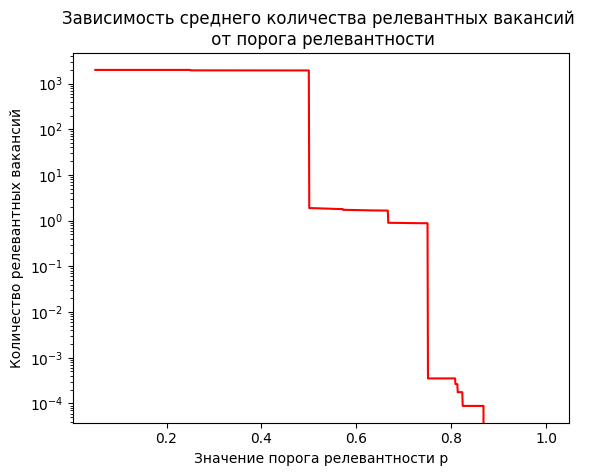

In [ ]:
x = np.array(list(num_relevance.keys()))
y = np.array(list(num_relevance.values()))

plt.title("Зависимость среднего количества релевантных вакансий \n от порога релевантности")
plt.xlabel("Значение порога релевантности p")
plt.ylabel("Количество релевантных вакансий")
plt.plot(x, y, color ="red")
plt.yscale('log')
plt.savefig('Relevance.png', dpi=500)

In [ ]:
# def get_res(matrix):

#     mask = np.array([[i for i in range(matrix.shape[1])] for j in range (matrix.shape[0])])

#     result = []

#     deleted_rows = []
#     deleted_columns = []

#     cur_matrix = matrix[mask]

#     while cur_matrix.size != 0:

#       cur_matrix = matrix[mask]

#       row_zeros = cur_matrix.shape[0] - np.count_nonzero(cur_matrix, axis=1)
#       column_zeros = cur_matrix.shape[1] - np.count_nonzero(cur_matrix, axis=0)

#       one_in_a_row = np.where(row_zeros == 1)[0]
#       one_in_a_column = np.where(column_zeros == 1)[0]

#       print(f"\n\nMatrix is {cur_matrix}")

#       if one_in_a_row.size != 0:

#         cur_row = one_in_a_row[0]
#         index = np.where(cur_matrix[cur_row, :] == 0)[0][0]

#         row_to_add = cur_row + sum(cur_row >= deleted_rows)
#         ind_to_add = index + sum(index >= deleted_columns)

#         mask = np.delete(mask, cur_row, axis=0)
#         mask = np.delete(mask, index, axis=1)

#         deleted_rows.append(row_to_add)
#         deleted_columns.append(ind_to_add)

#         print(f"[{row_to_add}, {ind_to_add}] by [{cur_row, index}]")

#         result.append((row_to_add, ind_to_add))

#       elif one_in_a_column.size != 0:

#         cur_column = one_in_a_column[0]
#         index = np.where(cur_matrix[:, cur_column] == 0)[0][0]

#         col_to_add = cur_column + sum(cur_column >= deleted_columns)
#         ind_to_add = index + sum(index >= deleted_rows)

#         mask = np.delete(mask, cur_column, axis=1)
#         mask = np.delete(mask, index, axis=0)

#         deleted_columns.append(col_to_add)
#         deleted_rows.append(ind_to_add)

#         print(f"[{ind_to_add}, {col_to_add}] by [{index, cur_column}]")

#         result.append((ind_to_add, col_to_add))

#       else:
#         break

#     print(f"RES: {result}")

#     return result

In [ ]:
# def get_max_zeros(matrix, deleted_rows=None, deleted_columns=None):

#   new_matrix = matrix.copy()
#   row_max, column_max = -1, -1

#   if deleted_rows is None:
#     deleted_rows = np.array([])
#   if deleted_columns is None:
#     deleted_columns = np.array([])

#   while (row_max != 0) | (column_max != 0):

#     row_zeros = new_matrix.shape[0] - np.count_nonzero(new_matrix, axis=0)
#     column_zeros = new_matrix.shape[1] - np.count_nonzero(new_matrix, axis=1)

#     if (sum(row_zeros) == 0) | (sum(column_zeros) == 0):
#       break

#     row_max, column_max = max(row_zeros), max(column_zeros)

#     row_ind = np.where(row_zeros == row_max)
#     column_ind = np.where(column_zeros == column_max)

#     needed_axis = row_max > column_max
#     indices = row_ind if needed_axis else column_ind

#     comparance_array = deleted_rows if needed_axis else deleted_columns

#     #print(f"New matrix is {new_matrix}")

#     add_numbers = []
#     for ind in indices[0]:
#         shift = sum(ind >= comparance_array)
#         add_numbers.append(ind+shift)

#     if needed_axis:
#       deleted_rows = np.concatenate([deleted_rows, add_numbers])
#     else:
#       deleted_columns = np.concatenate([deleted_columns, add_numbers])

#     new_matrix = np.delete(new_matrix, indices, axis=needed_axis)

#    #print(f"Super new matrix is {new_matrix}")

#     if new_matrix.size == 0:
#       break

#   return new_matrix, deleted_rows, deleted_columns


In [ ]:
# def hungarian(matrix):

#   if matrix.shape[0] != matrix.shape[1]:
#     print("Something wrong")
#   transformed_matrix = matrix.copy()

#   transformed_matrix = matrix - np.min(transformed_matrix, axis=1)[:,None]
#   transformed_matrix = transformed_matrix - np.min(transformed_matrix, axis=0)[None, :]

#   little_matrix = transformed_matrix.copy()

#   #print(f"Step one. {transformed_matrix}")

#   deleted_rows, deleted_columns = np.array([]), np.array([])

#   while (little_matrix.size != 0):

#     old_deleted_rows = deleted_rows.copy()
#     old_deleted_columns = deleted_columns.copy()

#     little_matrix, deleted_rows, deleted_columns = get_max_zeros(little_matrix, deleted_rows, deleted_columns)

#     column_location = np.array([i for i in range(matrix.shape[0]) if i not in deleted_columns])
#     row_location = np.array([i for i in range(matrix.shape[1]) if i not in deleted_rows])

#     newly_deleted_rows = np.array(list(set(deleted_rows) - set(old_deleted_rows)), dtype=int)
#     newly_deleted_columns = np.array(list(set(deleted_columns) - set(old_deleted_columns)), dtype=int)

#     indices = np.ix_(column_location, row_location)

#     add_indices = np.ix_(newly_deleted_columns, newly_deleted_rows)
#     print(product(newly_deleted_columns, newly_deleted_rows))

#     if (little_matrix.size != 0):
#         min_el = np.min(little_matrix)
#         transformed_matrix[indices] -= min_el
#         transformed_matrix[add_indices] += min_el
#         little_matrix -= min_el
#     else:
#       break

#     # print(f"Transformed.\n{transformed_matrix}")
#     # print(f"Little.\n{little_matrix}")
#     # print("\n\n")

#     nonzeros_in_rows = np.count_nonzero(transformed_matrix, axis=1)
#     nonzeros_in_columns = np.count_nonzero(transformed_matrix, axis=0)

#     # print(nonzeros_in_rows)
#     # print(nonzeros_in_columns)

#     matrix_size = transformed_matrix.shape[0]

#     if (nonzeros_in_rows != transformed_matrix.shape[0]) and (nonzeros_in_columns != transformed_matrix.shape[1]):
#       break


#     if little_matrix.size == 0:
#       break

#   # print('\n\n')
#   # print(transformed_matrix)
#   # print('\n\n')
#   return transformed_matrix
